In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# fix random seed for reproducibility
np.random.seed(100)
random.seed(100)

# Loading and short preprocessing

In [204]:
movies_plot = pd.read_csv('../data/processed/movies_with_classifications.csv')
movies = pd.read_csv('../data/processed/movies_summary_BO.csv')

### Parsing the string attributes

In [293]:
movies_budget = pd.read_csv('../data/processed/movies_budget_inflation_final.csv')

In [294]:
len(movies_budget)

5781

In [295]:
import ast
def safe_literal_eval(val):
	try:
		return ast.literal_eval(val)
	except (ValueError, SyntaxError):
		return val

# Ensure that the movie_genres column is parsed as lists
def parse_genres(genres):
    if isinstance(genres, list):
        return genres
    try:
        return ast.literal_eval(genres)
    except (ValueError, SyntaxError):
        return genres.strip('[]').replace("'", "").split(', ')

movies_budget['movie_languages'] = movies_budget['movie_languages'].apply(safe_literal_eval)
movies_budget['movie_countries'] = movies_budget['movie_countries'].apply(parse_genres)
movies_budget['movie_genres'] = movies_budget['movie_genres'].apply(parse_genres)

#movies_budget['year_interval'] = (movies_budget['movie_release_date'] // 5) * 5  

In [296]:
movies_budget.shape

(5781, 24)

In [297]:
movies_budget.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_release_date', 'movie_box_office_revenue', 'movie_runtime',
       'movie_languages', 'movie_countries', 'movie_genres', 'title_year',
       'plot_summary', 'opening_weekend', 'rating_score', 'producer', 'budget',
       'year_interval', 'profit', 'profitability_ratio', 'adjusted_revenue',
       'adjusted_budget', 'adjusted_profit', 'summarized', 'plot_structure',
       'plot_structure_20'],
      dtype='object')

### Adding the plot structure clusters

In [298]:
from sklearn.feature_extraction.text import TfidfVectorizer
# import KMeans
from sklearn.cluster import KMeans

# Text Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_budget['plot_summary'])

combined_matrix = tfidf_matrix.toarray()

# Clustering with KMeans
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
movies_budget['plot_structure_cluster'] = kmeans.fit_predict(combined_matrix)

# Processing for linear regression

In [323]:
def list_to_1_hot(df, column_name):
    mlb = MultiLabelBinarizer()
    one_hot_df = pd.DataFrame(mlb.fit_transform(df[column_name]), columns=mlb.classes_, index=df.index)
    df = pd.concat([df, one_hot_df], axis=1)
    df = df.drop(column_name, axis=1)
    return df

def split_x_y(df, y_column, x_columns_to_drop):
    y = df[y_column]
    x = df.drop(columns=x_columns_to_drop)
    return x, y

def split_train_test(x, y, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    return x_train, x_test, y_train, y_test

def scale_data(x_train, x_test):
    scaler = sklearn.preprocessing.StandardScaler()
    train = scaler.fit_transform(x_train)
    test = scaler.transform(x_test)
    x_train_df = pd.DataFrame(train, columns=x_train.columns)
    x_test_df = pd.DataFrame(test, columns=x_test.columns)
    return x_train_df, x_test_df

def preprocess4linreg(df, y_column, x_columns_to_drop, test_size=0.2):
    if 'plot_structure' not in x_columns_to_drop :
        df = pd.get_dummies(df, columns=['plot_structure'], drop_first=True, dtype=int)
    
    if 'movie_genres' not in x_columns_to_drop :
        df = list_to_1_hot(df, 'movie_genres')
    if 'plot_structure_cluster' not in x_columns_to_drop :
        df = pd.get_dummies(df, columns=['plot_structure_cluster'], drop_first=True, dtype=int)
    df = list_to_1_hot(df, 'movie_countries')
    x, y = split_x_y(df, y_column, x_columns_to_drop)
    x_train, x_test, y_train, y_test = split_train_test(x, y, test_size)
    x_train, x_test = scale_data(x_train, x_test)
    
    X_train_scaled_df = sm.add_constant(x_train,has_constant='add')
    X_test_scaled_df = sm.add_constant(x_test,has_constant='add')

    X_train_scaled_df = X_train_scaled_df.fillna(X_train_scaled_df.mean())
    X_test_scaled_df = X_test_scaled_df.fillna(X_train_scaled_df.mean())

    y_train_no_index = y_train.reset_index(drop=True)
    y_test_no_index = y_test.reset_index(drop=True)
    X_train_scaled_df = X_train_scaled_df.reset_index(drop=True)
    X_test_scaled_df = X_test_scaled_df.reset_index(drop=True)
    
    return X_train_scaled_df, X_test_scaled_df, y_train_no_index, y_test_no_index


# Predict profit

### without plot structure LLM and without clustering

In [324]:
# Features = [movie_release_date, budget, rating_score, movie_genres, movie_countries]
X_train, X_test, y_train, y_test = preprocess4linreg(movies_budget, y_column='profit', x_columns_to_drop=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'year_interval', 'summarized', 'plot_structure', 'plot_structure_20', 'producer', 'plot_structure_cluster', 'adjusted_revenue', 'adjusted_profit', 'adjusted_budget', 'profit', 'profitability_ratio'])
#X_train, X_test, y_train, y_test = preprocess4linreg(movies_budget, y_column='profit', x_columns_to_drop=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'summarized', 'plot_structure', 'plot_structure_20', 'producer', 'plot_structure_cluster', 'profit'])

# Fit the model
model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     10.55
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:32:15   Log-Likelihood:                -90752.
No. Observations:                4624   AIC:                         1.822e+05
Df Residuals:                    4268   BIC:                         1.845e+05
Df Model:                         355                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [325]:
import sklearn.metrics as metrics
y_pred = results.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
r2

0.34436181197315163

### with plot structure without genres

In [326]:
# Features = [movie_release_date, budget, rating_score, producer, movie_genres, movie_countries]
X_train_plot, X_test_plot, y_train_plot, y_test_plot = preprocess4linreg(movies_budget, 'profit', ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'year_interval', 'summarized', 'plot_structure_20', 'producer', 'movie_genres', 'plot_structure_cluster', 'adjusted_revenue', 'adjusted_profit','adjusted_budget','profit', 'profitability_ratio'])
#X_train_plot, X_test_plot, y_train_plot, y_test_plot = preprocess4linreg(movies_budget, y_column='profit', x_columns_to_drop=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'summarized', 'plot_structure_20', 'producer', 'plot_structure_cluster', 'profit', 'movie_genres'])

# Fit the model
model = sm.OLS(y_train_plot, X_train_plot)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     21.44
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          1.80e-289
Time:                        18:32:18   Log-Likelihood:                -91357.
No. Observations:                4624   AIC:                         1.829e+05
Df Residuals:                    4529   BIC:                         1.835e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [327]:
y_pred = results.predict(X_test_plot)
r2 = metrics.r2_score(y_test_plot, y_pred)
r2

0.3443406450146358

### with plot structure and genres

In [328]:
# Features = [movie_release_date, budget, rating_score, producer, movie_genres, movie_countries]
X_train_plot, X_test_plot, y_train_plot, y_test_plot = preprocess4linreg(movies_budget, 'profit', ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'year_interval', 'summarized', 'plot_structure_20', 'producer', 'plot_structure_cluster', 'adjusted_revenue', 'adjusted_profit', 'adjusted_budget', 'profit', 'profitability_ratio'])
#X_train_plot, X_test_plot, y_train_plot, y_test_plot = preprocess4linreg(movies_budget, y_column='profit', x_columns_to_drop=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'summarized', 'plot_structure_20', 'producer', 'plot_structure_cluster', 'profit'])

# Fit the model
model = sm.OLS(y_train_plot, X_train_plot)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     10.30
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:32:21   Log-Likelihood:                -90732.
No. Observations:                4624   AIC:                         1.822e+05
Df Residuals:                    4254   BIC:                         1.846e+05
Df Model:                         369                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [329]:
y_pred = results.predict(X_test_plot)
r2 = metrics.r2_score(y_test_plot, y_pred)
r2

0.34314039853161515

### adding plot_structure clustering


In [330]:
# Features = [movie_release_date, budget, rating_score, producer, movie_genres, movie_countries]
X_train_plot, X_test_plot, y_train_plot, y_test_plot = preprocess4linreg(movies_budget, 'profit', ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'year_interval', 'summarized', 'plot_structure_20', 'producer', 'adjusted_revenue', 'adjusted_profit', 'adjusted_budget', 'profit', 'profitability_ratio'])
#X_train_plot, X_test_plot, y_train_plot, y_test_plot = preprocess4linreg(movies_budget, y_column='profit', x_columns_to_drop=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_box_office_revenue', 'movie_languages', 'title_year', 'plot_summary', 'opening_weekend', 'summarized', 'plot_structure_20', 'producer', 'profit'])

# Fit the model
model = sm.OLS(y_train_plot, X_train_plot)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     10.05
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:32:25   Log-Likelihood:                -90716.
No. Observations:                4624   AIC:                         1.822e+05
Df Residuals:                    4240   BIC:                         1.847e+05
Df Model:                         383                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [331]:
y_pred = results.predict(X_test_plot)
r2 = metrics.r2_score(y_test_plot, y_pred)
r2

0.3402398165925852

# Budget is an important factor for predicting the profit

Blabla sur le fait que budget high influence on profit

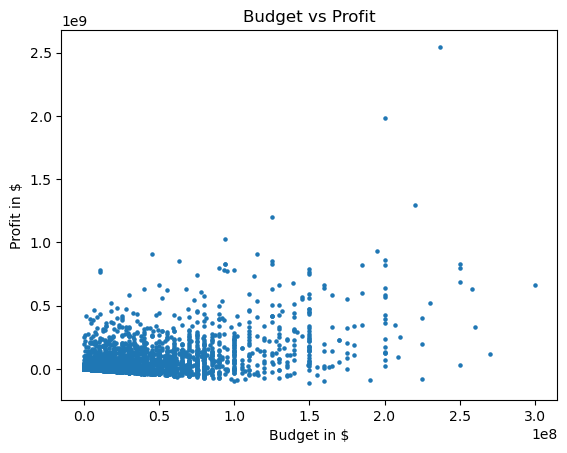

In [268]:
# plot budget vs profit
plt.scatter(movies_budget['budget'], movies_budget['profit'],s=5)
plt.xlabel('Budget in $')
plt.ylabel('Profit in $')
# make the markers smaller
plt.title('Budget vs Profit')
plt.show()


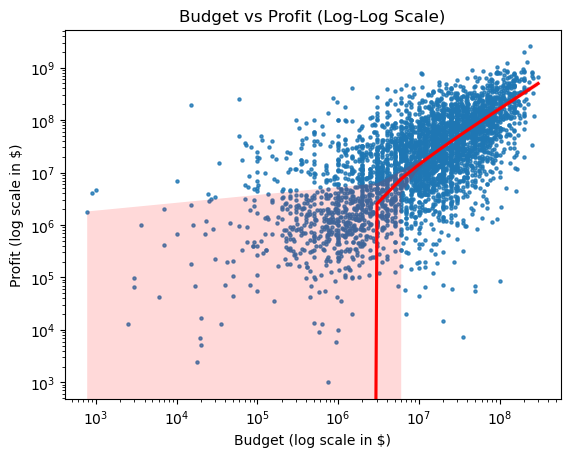

In [286]:
# plot budget vs profit in log-log scale
sns.regplot(x=movies_budget['budget'], y=movies_budget['profit'], scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Budget (log scale in $)')
plt.ylabel('Profit (log scale in $)')
plt.title('Budget vs Profit (Log-Log Scale)')
plt.show()

In [271]:
# Compute Pearson and Spearman correlations
pearson_corr = movies_budget['budget'].corr(movies_budget['profit'], method='pearson')
spearman_corr = movies_budget['budget'].corr(movies_budget['profit'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

Pearson Correlation: 0.502
Spearman Correlation: 0.192


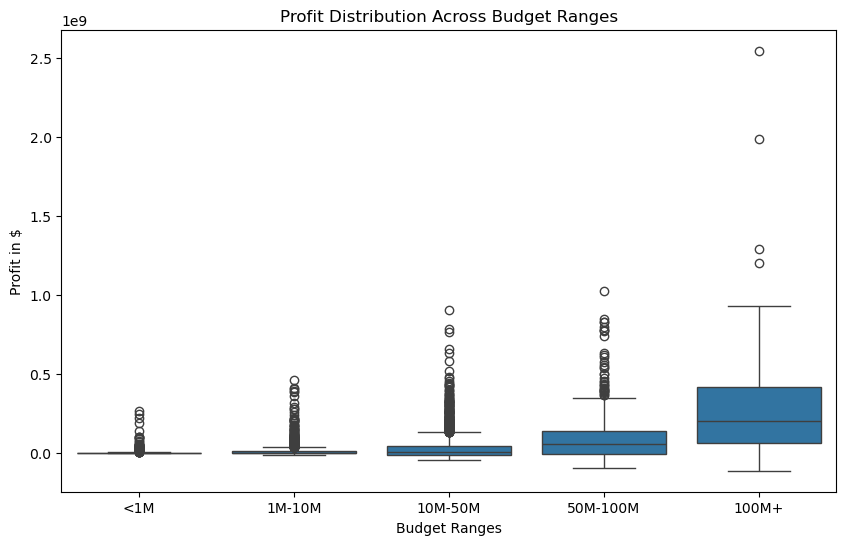

In [276]:
import seaborn as sns

# Create budget bins
bins = [0, 1e6, 1e7, 5e7, 1e8, 5e8]
labels = ['<1M', '1M-10M', '10M-50M', '50M-100M', '100M+']
movies_budget['budget_bins'] = pd.cut(movies_budget['budget'], bins=bins, labels=labels)

# Box plot of profit across budget bins
plt.figure(figsize=(10, 6))
sns.boxplot(x='budget_bins', y='profit', data=movies_budget)
plt.xlabel('Budget Ranges')
plt.ylabel('Profit in $')
plt.title('Profit Distribution Across Budget Ranges')
plt.show()

In [279]:
from scipy.stats import f_oneway

# Create budget bins for ANOVA
budget_groups = [movies_budget[movies_budget['budget_bins'] == label]['profit'] for label in labels]

# Perform ANOVA
anova_result = f_oneway(*budget_groups)
print(f"ANOVA Test: F-statistic={anova_result.statistic:.2f}, p-value={anova_result.pvalue:.2e}")

if anova_result.pvalue < 0.05:
    print("Significant differences exist between budget bins.")
else:
    print("No significant differences between budget bins.")

ANOVA Test: F-statistic=424.73, p-value=2.65e-321
Significant differences exist between budget bins.


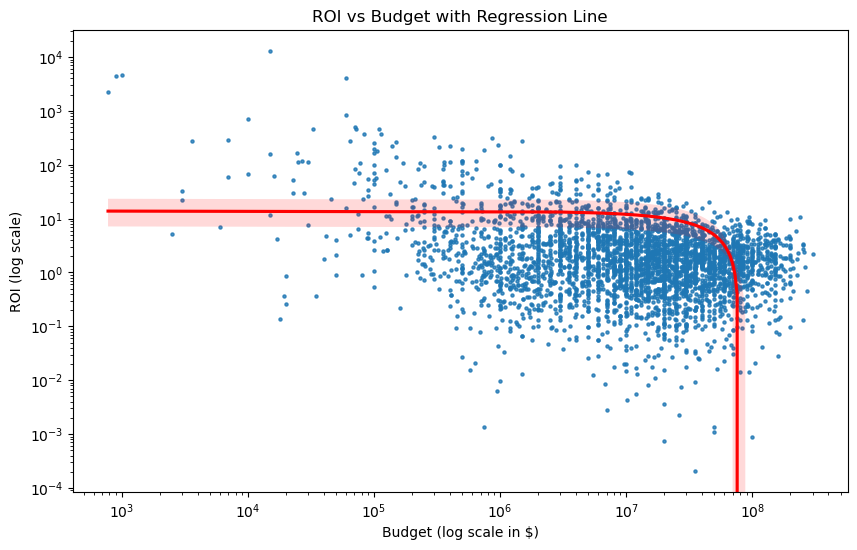

In [332]:
# plot budget vs profit in log-log scale
movies_budget['profitability_ratio'] = movies_budget['profit'] / movies_budget['budget']

plt.figure(figsize=(10, 6))
sns.regplot(x=movies_budget['budget'], y=movies_budget['profitability_ratio'], scatter_kws={'s': 5}, line_kws={'color': 'red'})
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Budget (log scale in $)')
plt.ylabel('ROI (log scale)')
plt.title('ROI vs Budget with Regression Line')
plt.show()

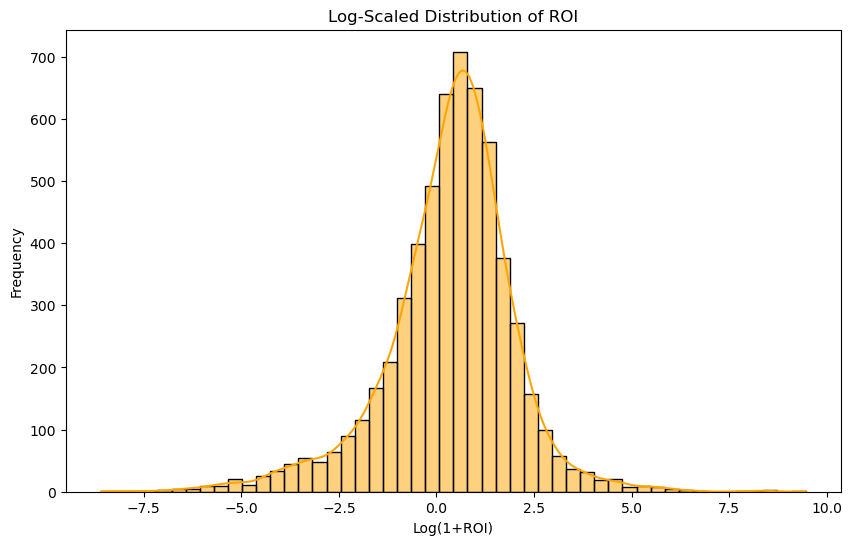

In [282]:
# Log-scale ROI histogram (to handle outliers)
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(movies_budget['profitability_ratio']), bins=50, kde=True, color='orange')
plt.xlabel('Log(1+ROI)')
plt.ylabel('Frequency')
plt.title('Log-Scaled Distribution of ROI')
plt.show()

/var/folders/34/0658nngn4kg11s2f10mpfs540000gn/T/ipykernel_67810/2139541260.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  roi_by_budget_bin = movies_budget.groupby('budget_bins')['profitability_ratio'].agg(['mean', 'median', 'std']).reset_index()


ROI Summary by Budget Range:
  budget_bins       mean    median         std
0         <1M  82.423435  2.525424  667.787291
1      1M-10M   3.265059  0.622173   10.645925
2     10M-50M   1.468603  0.385179    3.799108
3    50M-100M   1.293041  0.807500    2.014986
4       100M+   1.822208  1.353310    1.934109


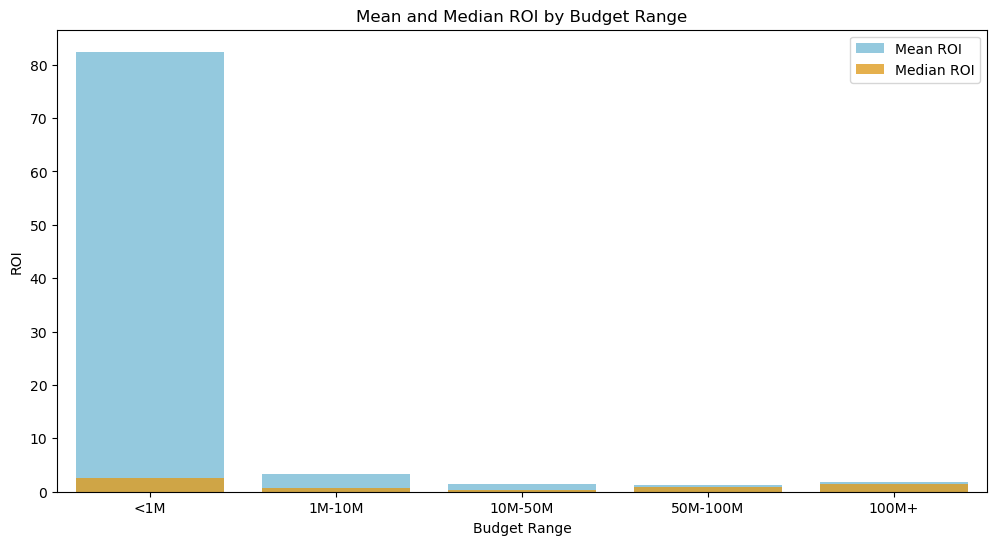

In [283]:
# Group ROI by budget bins and calculate mean and median
roi_by_budget_bin = movies_budget.groupby('budget_bins')['profitability_ratio'].agg(['mean', 'median', 'std']).reset_index()
print("ROI Summary by Budget Range:")
print(roi_by_budget_bin)

# Bar plot of ROI mean and median by budget range
plt.figure(figsize=(12, 6))
sns.barplot(data=roi_by_budget_bin, x='budget_bins', y='mean', color='skyblue', label='Mean ROI')
sns.barplot(data=roi_by_budget_bin, x='budget_bins', y='median', color='orange', label='Median ROI', alpha=0.8)
plt.xlabel('Budget Range')
plt.ylabel('ROI')
plt.title('Mean and Median ROI by Budget Range')
plt.legend()
plt.show()

In [284]:
from scipy.stats import f_oneway, kruskal

# Prepare ROI groups for ANOVA
roi_groups = [movies_budget[movies_budget['budget_bins'] == label]['profitability_ratio'] for label in labels]

# Perform ANOVA
anova_roi_result = f_oneway(*roi_groups)
print(f"ANOVA Test for ROI: F-statistic={anova_roi_result.statistic:.2f}, p-value={anova_roi_result.pvalue:.2e}")

if anova_roi_result.pvalue < 0.05:
    print("Significant differences in ROI exist between budget ranges (ANOVA).")
else:
    print("No significant differences in ROI across budget ranges (ANOVA).")

# Perform Kruskal-Wallis test (non-parametric)
kruskal_result = kruskal(*roi_groups)
print(f"Kruskal-Wallis Test for ROI: H-statistic={kruskal_result.statistic:.2f}, p-value={kruskal_result.pvalue:.2e}")

if kruskal_result.pvalue < 0.05:
    print("Significant differences in ROI exist between budget ranges (Kruskal-Wallis).")
else:
    print("No significant differences in ROI across budget ranges (Kruskal-Wallis).")

ANOVA Test for ROI: F-statistic=19.06, p-value=1.38e-15
Significant differences in ROI exist between budget ranges (ANOVA).
Kruskal-Wallis Test for ROI: H-statistic=235.09, p-value=1.06e-49
Significant differences in ROI exist between budget ranges (Kruskal-Wallis).
